In [144]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
import sys
from pathlib import Path
import json
import random
import re
import uuid
import shutil
import os
from functools import partial
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

random.seed()

In [146]:
project_path = '/datadisk2/qfeng/TextRecognitionDataGenerator'

if project_path not in sys.path:
    sys.path.append(project_path)
    
%cd $project_path
%pwd

/datadisk2/qfeng/TextRecognitionDataGenerator


'/datadisk2/qfeng/TextRecognitionDataGenerator'

**1. Set the parameters: input corpus directory and output image directory**

In [147]:
font_file = '/datadisk2/qfeng/TextRecognitionDataGenerator/trdg/fonts/cn/仿宋GB2312.ttf'
font = 'fangsong'
word_len = 15

if word_len == 5:
    width = 160
elif word_len == 10:
    width = 320
elif word_len == 15:
    width = 480
else:
    raise Error('Wrong word_len')

inp_dir = Path('/datadisk2/qfeng/ocr_synthesis/jieba_texts/{}_lens'.format(word_len))
outp_path = Path('/datadisk2/qfeng/ocr_synthesis/jieba_outp/{}_lens/{}'.format(word_len, font))

if outp_path.exists():
    shutil.rmtree(str(outp_path))
outp_path.mkdir()

In [148]:
inp_texts = []

for p in inp_dir.glob('*'):
    with open(str(p), 'r') as f:        
        for line in f.readlines():
            inp_texts.append(line.strip('\n'))
            
len(inp_texts)

2000000

In [149]:
inp_texts[:10]

['决特别搜索是初期管理追到不能由',
 '开始自行建筑折服封建后投感到就',
 '德国的军随角度四十八化学的英国',
 '可公告打招呼在伤口小对增加系统',
 '自挨着惨变个这过去奴隶你坐在街',
 '对比这就力量老者墓历国家的爷味',
 '的在礼部整体之出均的便于的离馅',
 '是佛公布想其余鲁迅没有我国森林',
 '清来站新疆文明们工作到四川困时',
 '绝对是等分钟作为计划了黄自治区']

In [150]:
from trdg.generators import CompoundGenerator
from collections import namedtuple

**2. Set the parameters: fix configurations**

In [151]:
conf = namedtuple('Conf', ['width', 'background_type', 'fit', 'line_margin', 'skewing_angle', 'random_skew', 'box_skewing_angle', 'box_random_skew', 'size'])
conf.size = 32
conf.background_type = 1
conf.fit = True
conf.line_margin = 0
conf.skewing_angle = 1
conf.random_skew = True
conf.box_skewing_angle = 1
conf.box_random_skew = True

In [152]:
generator = CompoundGenerator(conf=conf, width=width)

**3. Set the parameters: random configurations**

In [153]:
def gen_image(text):    
    args = namedtuple('Args', ['font', 'texts', 'bold', 'box_margins', 'box_lines', 'alignment'])
    n_texts = 1
    args.texts = [text]   
    args.font = font_file
    args.bold = False
    args.box_margins = (0, 0)
    args.box_lines = [random.randint(0,1), random.randint(0,1), random.randint(0,1), random.randint(0,1)]
    args.alignment = random.randint(0, 1)
    args.draw_box = False
    img, img_locs = generator.gen(args)
    return img, img_locs, args.texts

(480, 32)


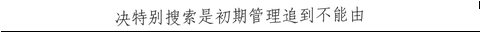

In [154]:
# Test generating one image
img, img_locs, c = gen_image(inp_texts[0])
print(img.size)
img

In [155]:
def save_generated(tag, inp_texts, font):
    gt_dname = outp_path/(tag + '_gt')
    img_dname = outp_path/(tag + '_img')
   
    if gt_dname.exists():
        shutil.rmtree(str(gt_dname))
    gt_dname.mkdir()
        
    if img_dname.exists():
        shutil.rmtree(str(img_dname))
    img_dname.mkdir()
    
    for t in inp_texts:
        img, img_locs, contents = gen_image(t)
        name = str(uuid.uuid4())
        img.save(str((img_dname/(name + '.png'))))
        
        with open(str(gt_dname/(name + '.txt')), 'w') as f:            
            for c, loc in zip(contents, img_locs):
                line = []
                for i_ in loc:
                    line.append(str(round(i_[0], 2)))
                    line.append(str(round(i_[1], 2)))
                line.append('"' + c + '"')
                line.append(font)
                f.write(','.join(line) + '\n')
                

def parallel_save(tag, inp, n_splits, font, n_workers):
    """
    Will generate 2 * n_splits folders (half images and half labels).
    Each folder has bs images or labels.
    """
    with ProcessPoolExecutor(max_workers=n_workers) as ex:
        func = partial(save_generated, font=font)
        step = len(inp)//n_splits
        splits = list(range(0, len(inp), step))
        for i in range(1, len(splits)):
            print(splits[i-1], splits[i])
            ex.submit(func, tag + '_' + str(i), inp[splits[i-1]:splits[i]])

In [156]:
n_splits = 200
n_workers = n_splits//2 if n_splits > 100 else 50
parallel_save(tag='{}_lens_{}'.format(word_len, font), inp=inp_texts, n_splits=n_splits, font=font, n_workers=n_workers)

0 10000
10000 20000
20000 30000
30000 40000
40000 50000
50000 60000
60000 70000
70000 80000
80000 90000
90000 100000
100000 110000
110000 120000
120000 130000
130000 140000
140000 150000
150000 160000
160000 170000
170000 180000
180000 190000
190000 200000
200000 210000
210000 220000
220000 230000
230000 240000
240000 250000
250000 260000
260000 270000
270000 280000
280000 290000
290000 300000
300000 310000
310000 320000
320000 330000
330000 340000
340000 350000
350000 360000
360000 370000
370000 380000
380000 390000
390000 400000
400000 410000
410000 420000
420000 430000
430000 440000
440000 450000
450000 460000
460000 470000
470000 480000
480000 490000
490000 500000
500000 510000
510000 520000
520000 530000
530000 540000
540000 550000
550000 560000
560000 570000
570000 580000
580000 590000
590000 600000
600000 610000
610000 620000
620000 630000
630000 640000
640000 650000
650000 660000
660000 670000
670000 680000
680000 690000
690000 700000
700000 710000
710000 720000
720000 730000
7